In [3]:
import os

folders = {
	'death': '1',
	'zenit': '2',
	'loko': '3'
}

text_dict = {}

for key, folder in folders.items():
	text_array = []
	for filename in os.listdir(folder):
		if filename.endswith('.txt'):
			with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
				text_array.append(file.read())
	text_dict[key] = text_array

texts = [
	text_array 
	for text in text_dict.values()
	for text_array in text
	]
texts

['Трагическая случайность.\n\nВ ПариМатч МХЛ стартовал плей-офф, одну из пар составили «Локо» и «Динамо» из Санкт-Петербурга – во втором матче серии динамовцы не только проиграли 1:5 (0-2 в серии), но и потеряли защитника Тимура Файзутдинова.\nТравма защитника выглядела жутко – он не мог встать и покинул лед только на носилках. А после матча «Динамо» опубликовало шокирующее заявление.\n\n«Тимур Файзутдинов начал этот сезон в качестве капитана молодежной команды «Динамо Санкт-Петербург». В свои 19 лет Тим провел за нашу команду почти 200 матчей, и он из тех игроков, для кого не было ни одной игры, ни единой смены, когда бы он не бился за команду и не дрался за результат.\n\nВ матче плей-офф Тимур в игровой ситуации поймал на себя шайбу. Сейчас он в реанимации, и за его жизнь сражаются ярославские врачи».\n\nС тех пор состояние игрока не улучшилось – он все еще находится в Ярославле и борется за жизнь. Точного диагноза нет, но, предположительно, шайба попала в сонную артерию – комментари

In [4]:
import nltk
import pymorphy3


morph = pymorphy3.MorphAnalyzer()
nltk_stopwords = nltk.corpus.stopwords.words('russian')

corpuses = []

for text in texts:
	text = text.lower()
	words = nltk.word_tokenize(text, language='russian')
	words = [word for word in words if word not in nltk_stopwords]
	words = [morph.parse(word)[0].normal_form for word in words]
	words = [word for word in words if word.isalpha()]
	
	corpuses.append(' '.join(words))


corpuses, len(corpuses)

(['трагический случайность париматч мхл стартовать один пара составить локо динамо второй матч серия динамовец проиграть серия потерять защитник тимур файзутдинов травма защитник выглядеть жутко мочь встать покинуть лёд носилки матч динамо опубликовать шокировать заявление тимур файзутдин начать сезон качество капитан молодёжный команда динамо свой год тим провести наш команда матч тот игрок кто один игра единый смена биться команда драться результат матч тимур игровой ситуация поймать шайба реанимация жизнь сражаться ярославский врач тот пора состояние игрок улучшиться находиться ярославль бороться жизнь точный диагноз предположительно шайба попасть сонный артерия комментарий официальный сообщество динамо оставить отец тимур травма файзутдинов роковой стечение обстоятельство вариант который мочь привести повреждение сонный артерия поскольку повтор очень сложно разглядеть именно попасть шайба первый шайба попасть шея тимур проходить сонный артерия такой случай очень редкий заканчиватьс

In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt


In [6]:
def plot_top_words(model, feature_names, n_top_words, title):
	fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
	axes = axes.flatten()
	for topic_idx, topic in enumerate(model.components_):
		top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
		top_features = [feature_names[i] for i in top_features_ind]
		weights = topic[top_features_ind]

		ax = axes[topic_idx]
		ax.barh(top_features, weights, height=0.7)
		ax.set_title(f'Topic {topic_idx +1}',
					 fontdict={'fontsize': 30})
		ax.invert_yaxis()
		ax.tick_params(axis='both', which='major', labelsize=20)
		for i in 'top right left'.split():
			ax.spines[i].set_visible(False)
		fig.suptitle(title, fontsize=40)

	plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
	plt.show()

In [7]:
n_features = 1000
n_components = 3
n_top_words = 20


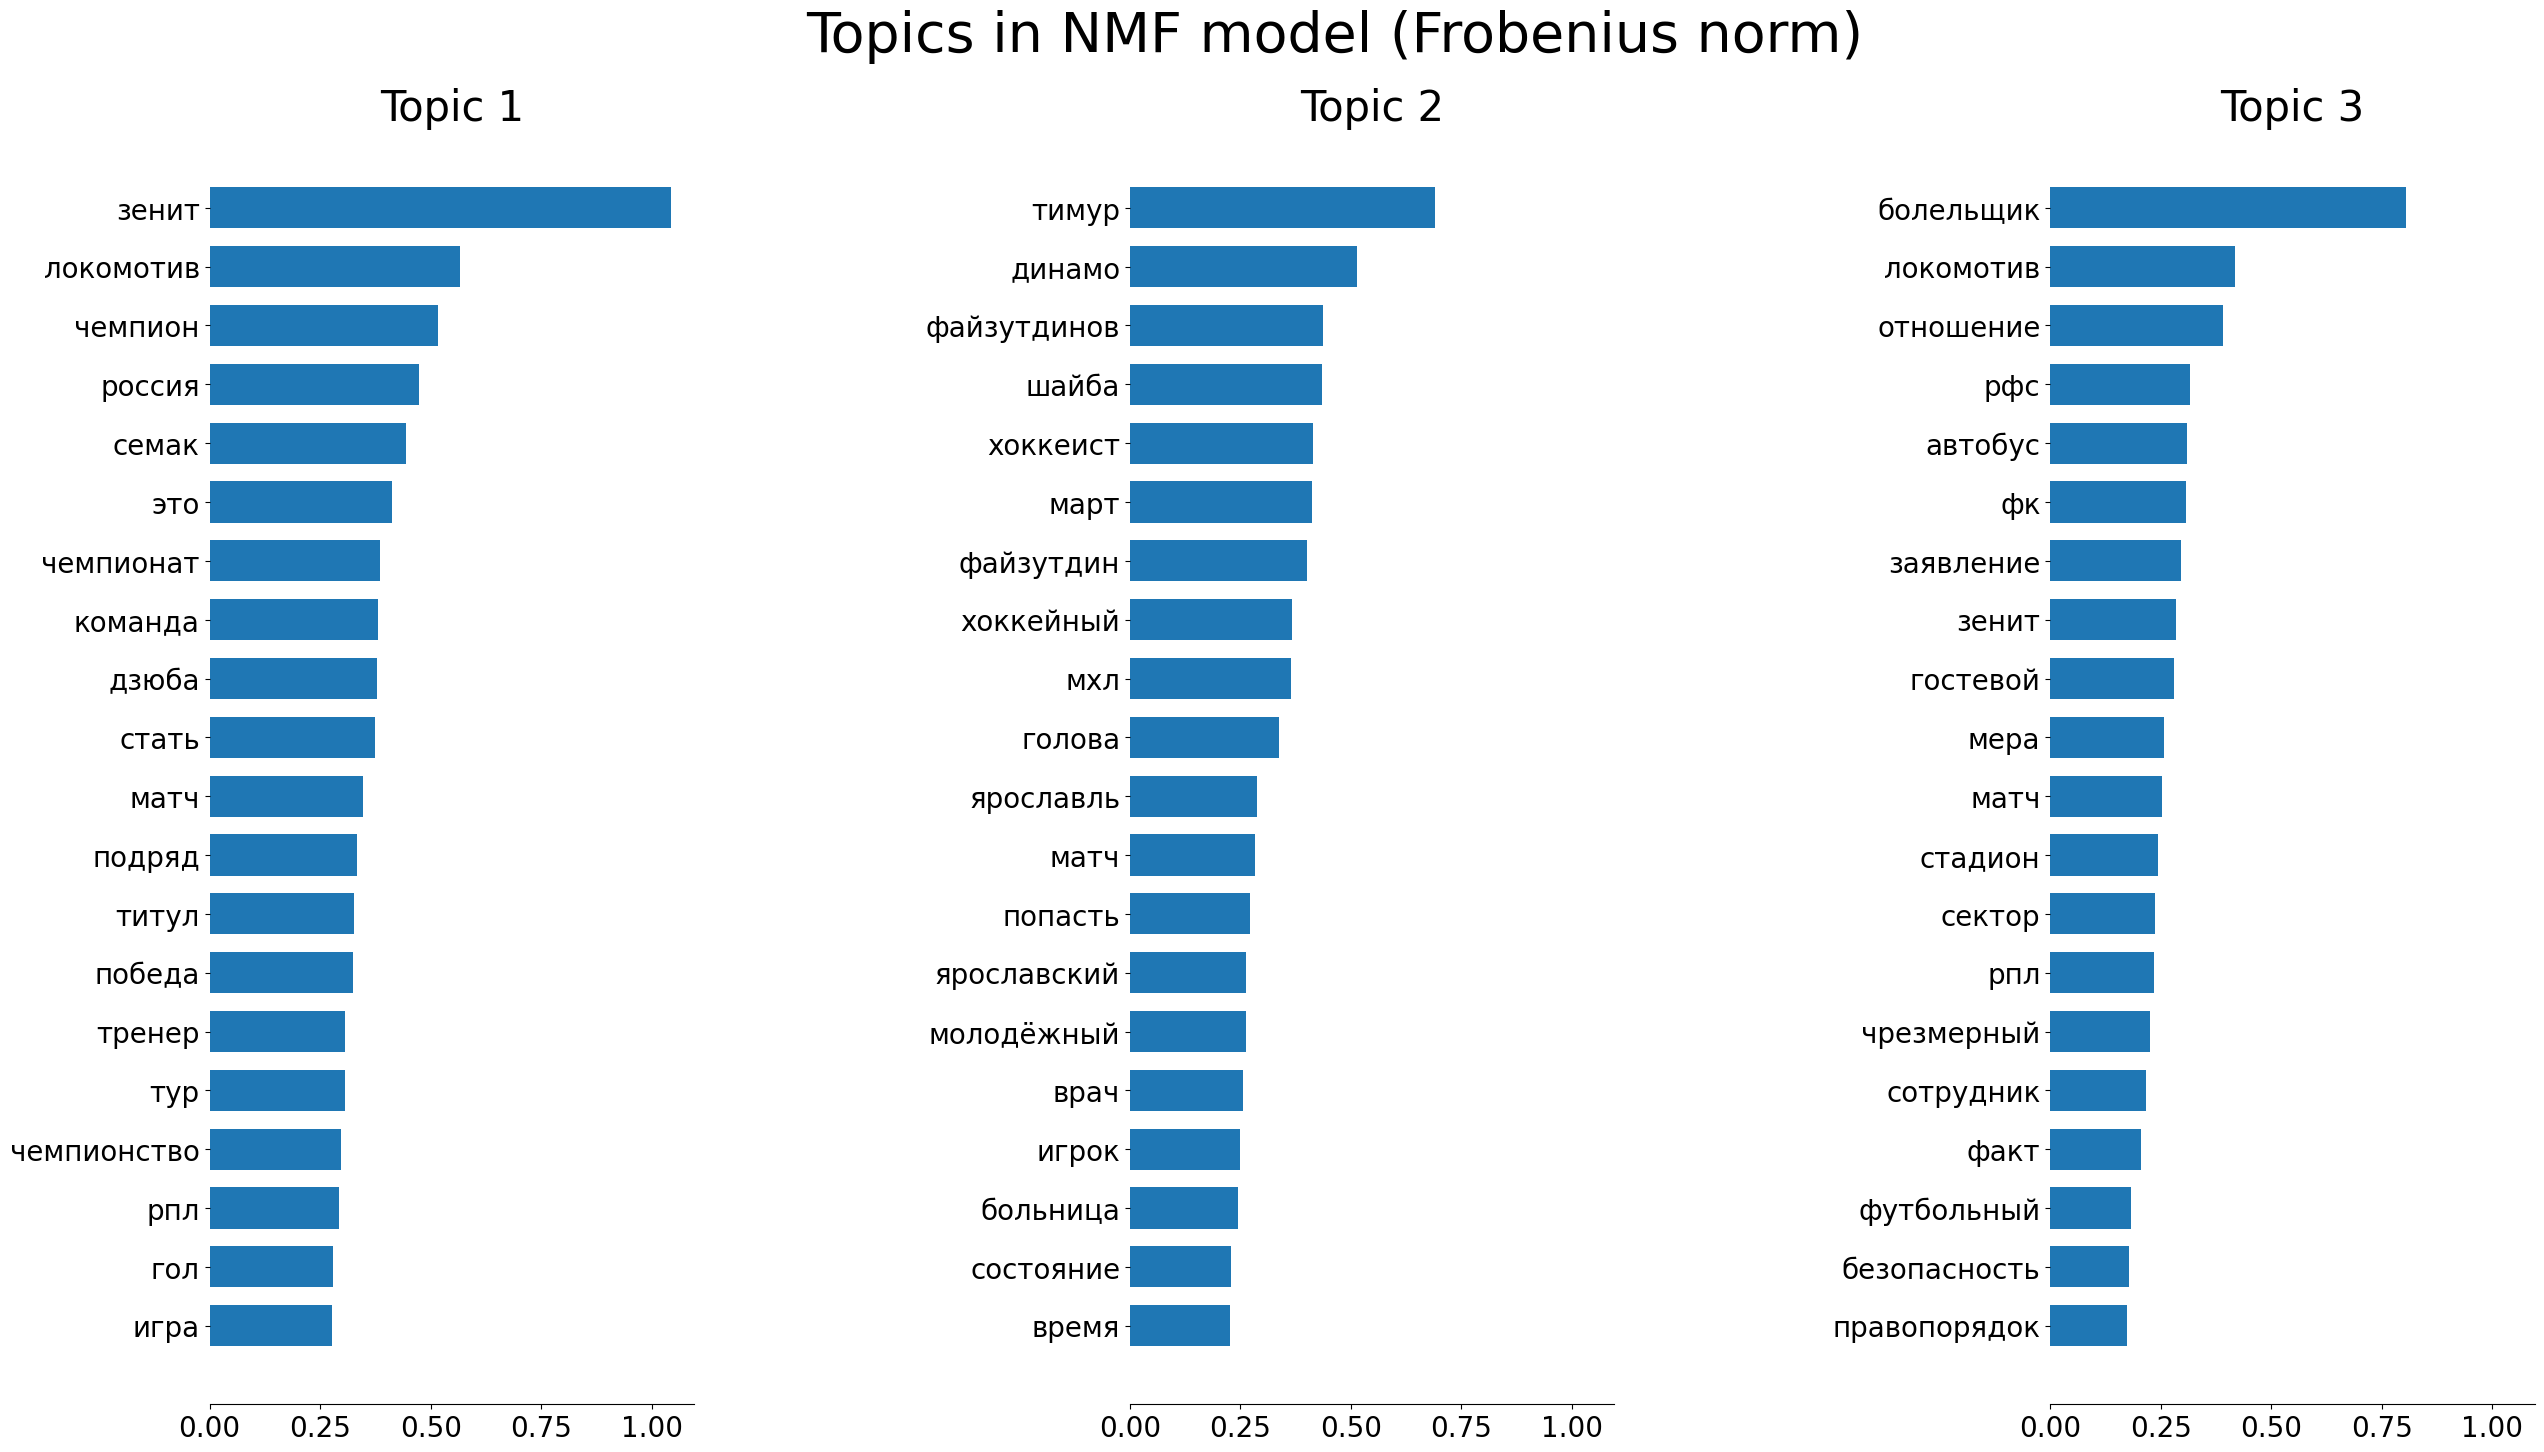

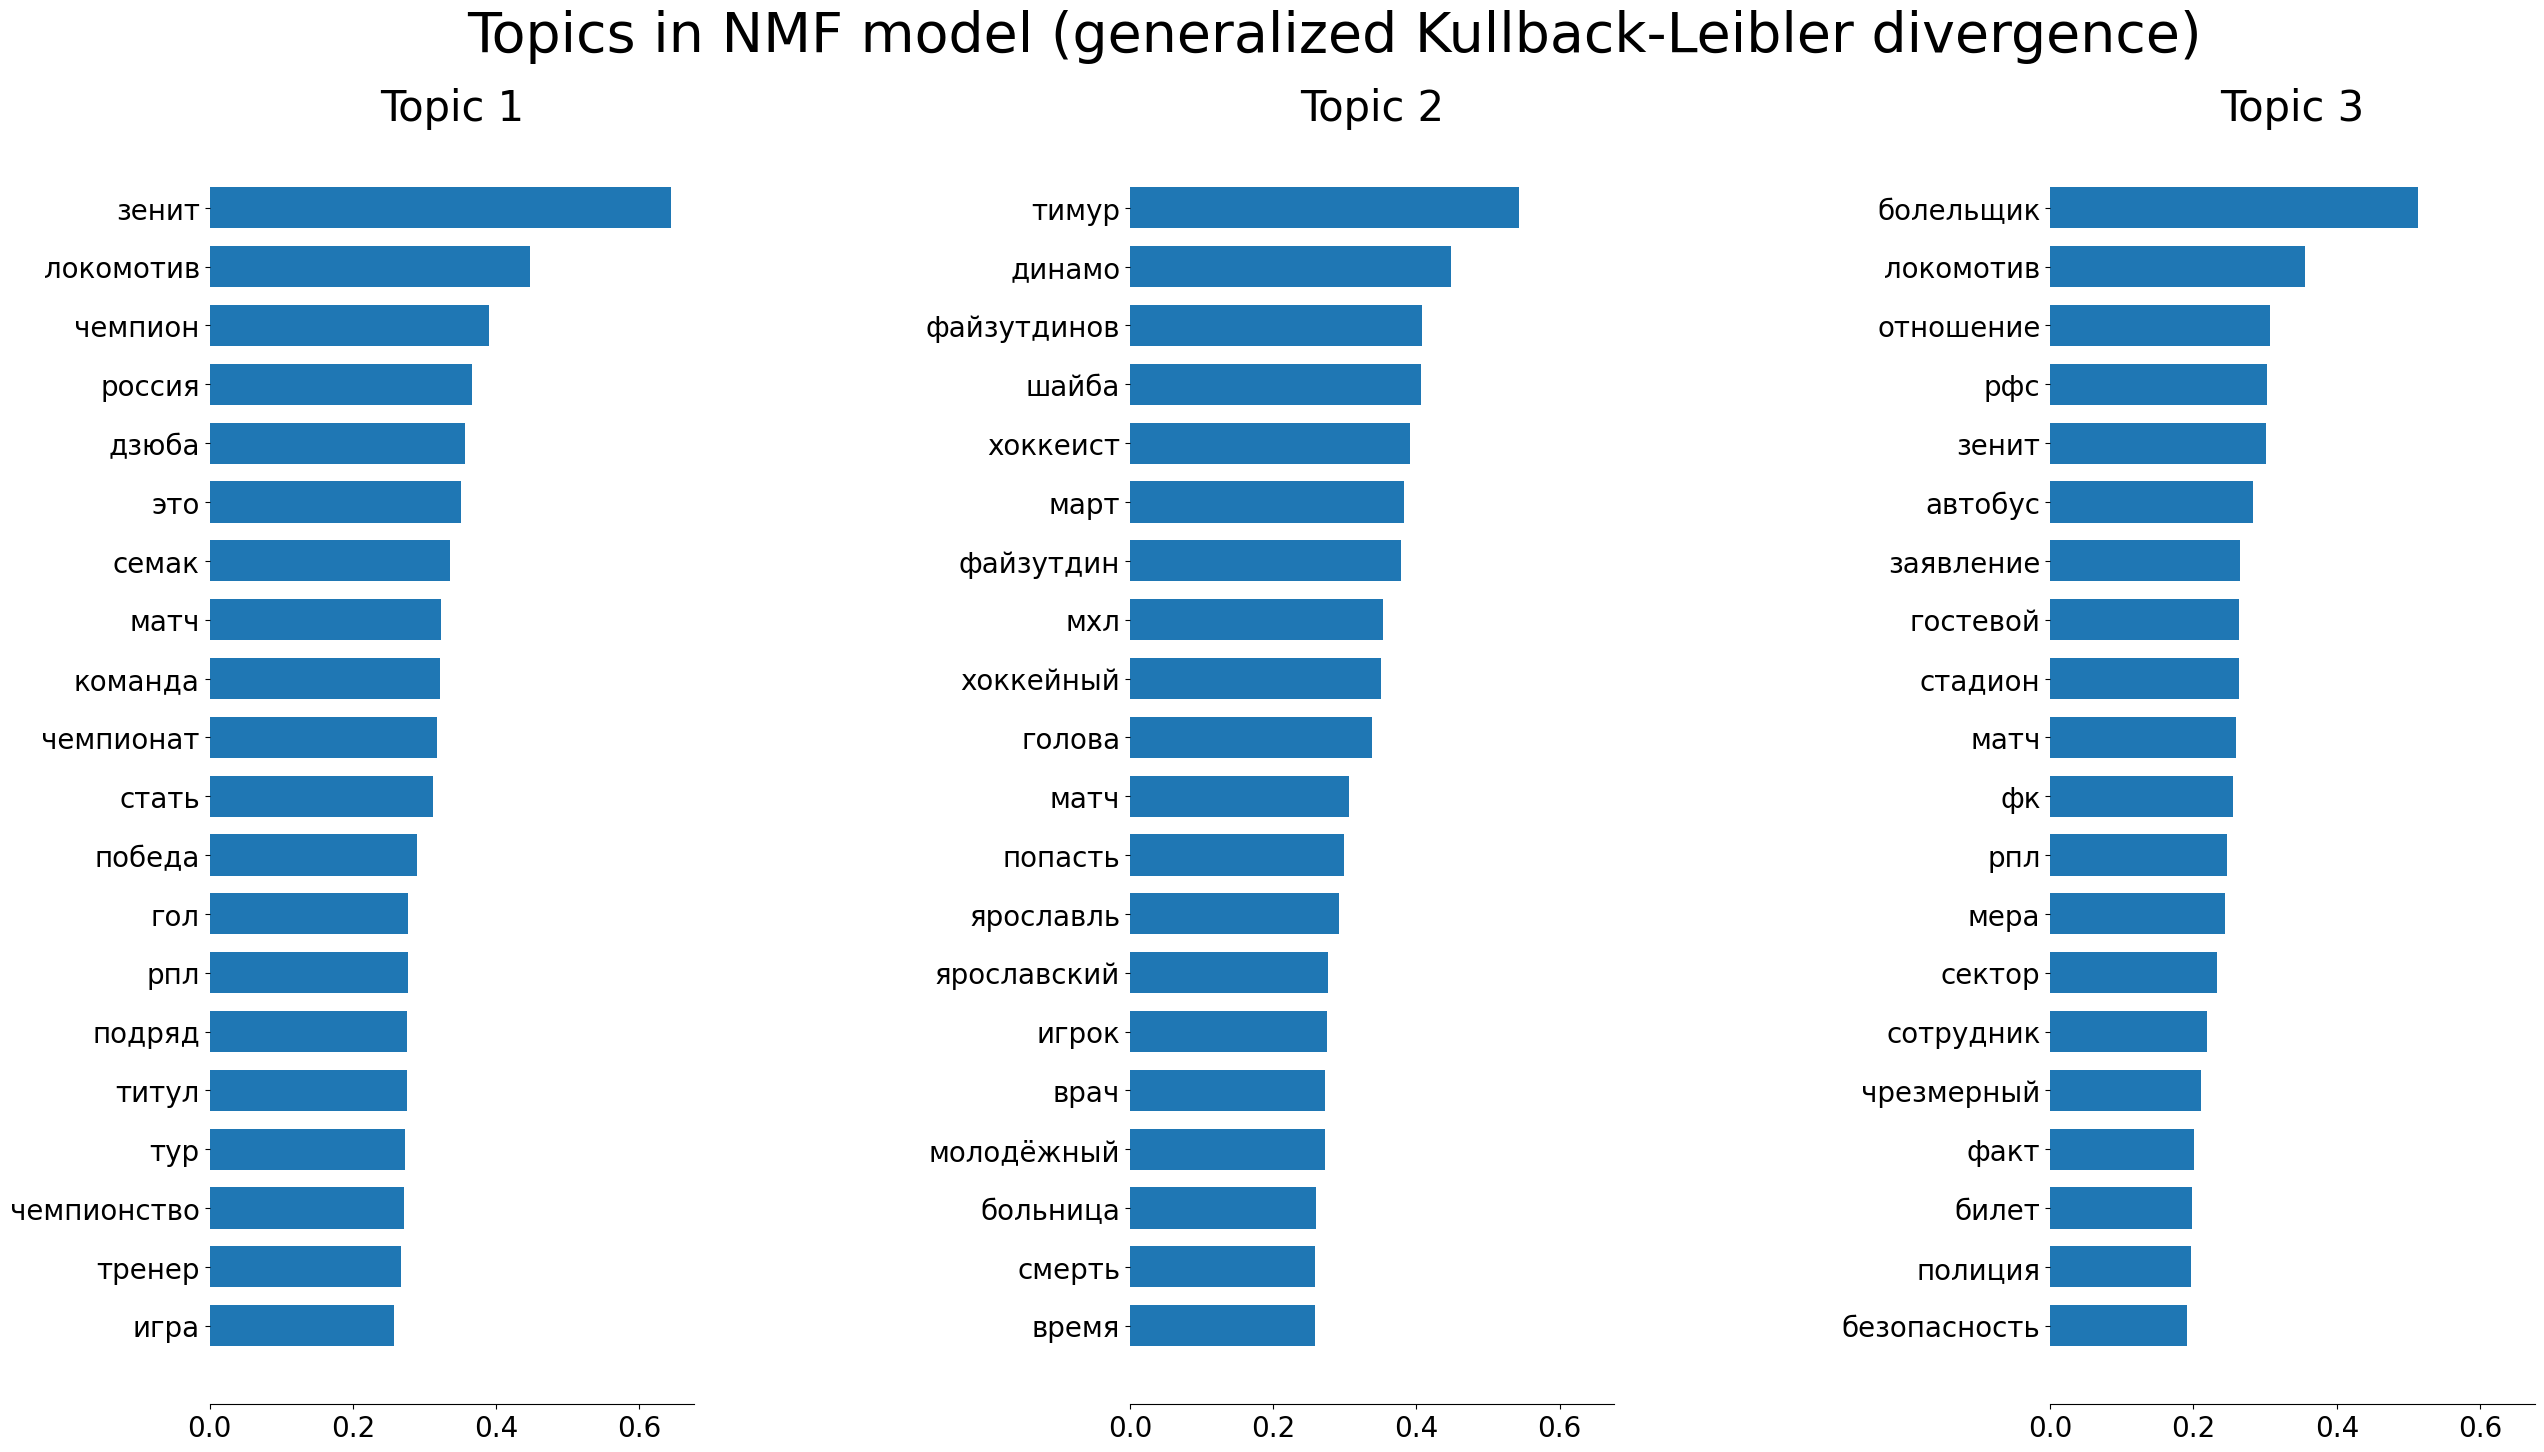

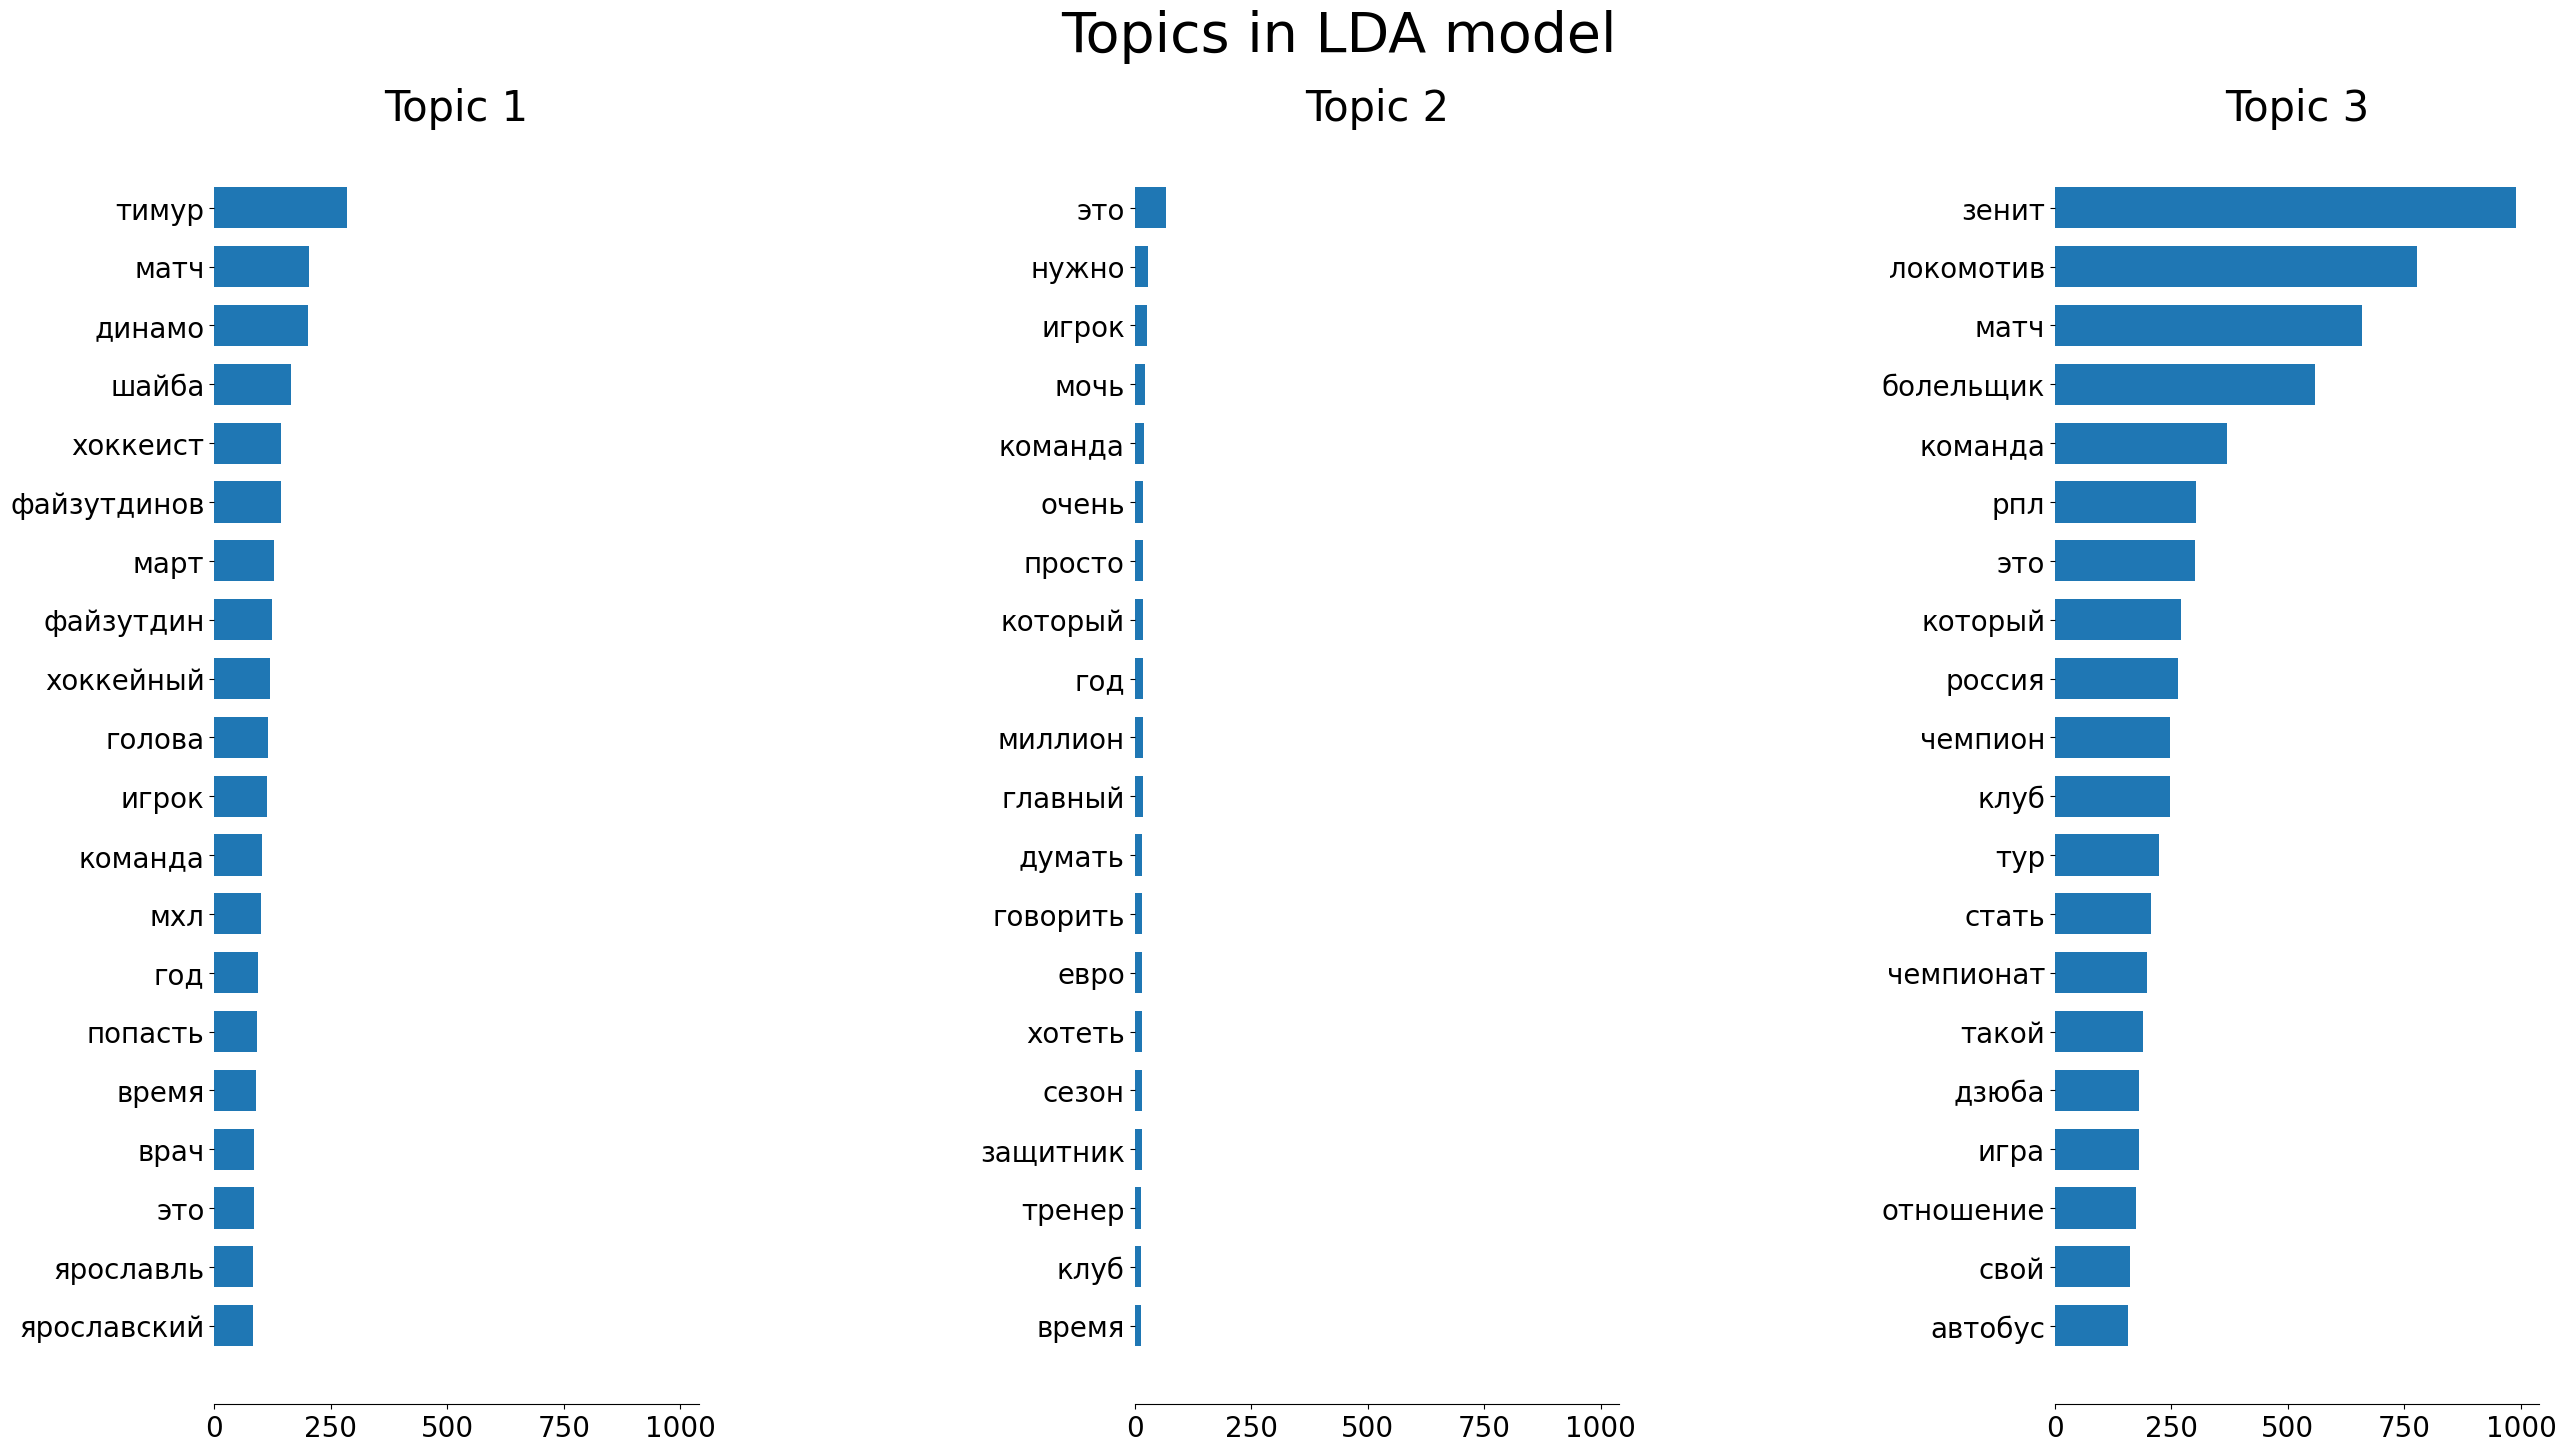

In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=n_features)
tfidf = tfidf_vectorizer.fit_transform(corpuses)

nmf = NMF(n_components=n_components, random_state=1, l1_ratio=.5).fit(tfidf)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(nmf, tfidf_feature_names, n_top_words, 'Topics in NMF model (Frobenius norm)')

nmf_k = NMF(n_components=n_components, random_state=1, alpha_W=.1, alpha_H=.1, beta_loss='kullback-leibler', solver='mu', max_iter=1000).fit(tfidf)
plot_top_words(nmf_k, tfidf_feature_names, n_top_words, 'Topics in NMF model (generalized Kullback-Leibler divergence)')

tf_vectorizer = CountVectorizer(max_features=n_features)
tf = tf_vectorizer.fit_transform(corpuses)

lda = LatentDirichletAllocation(n_components=n_components, max_iter=50, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
tf_feature_names = tf_vectorizer.get_feature_names_out()

plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')